# 03 Koreksi *Baseline* pada Akselerogram

Pada praktik kali ini kita akan mengolah seperti pada referensi oleh David M. Boore: David M. Boore: [Effect of baseline corrections on displacements and response spectra for several recordings of the 1999 Chi-Chi, Taiwan, earthquake](https://pubs.usgs.gov/of//1999/0545/#:~:text=USGS%20Open-File%20Report%2099-545%3A%20Effect%20of%20Baseline%20Corrections,Two%20Recordings%20of%20the%201999%20Chi-Chi%2C%20Taiwan%2C%20Earthquake). Rekaman ini dihasilkan oleh gempa M 7.6 Chi-Chi Taiwan pada 9 September 1999 pada jaringan CWB yang dikelola oleh Central Weather Bureau Taiwan. Stasiun yang akan diolah adalah stasiun TCU129 pada jaringan WBU, stasiun ini berada dekat dengan patahan.  

![station map boore](https://simpan.ugm.ac.id/s/orTGBZAH6ewwfvn/download)

Data akselerogram sangat berguna dan dapat dimanfaatkan untuk keperluan ekstraksi simpangan tanah coseismik dari hasil integrasi dua kali akselerasi (Boore, 1999; Wu dan Wu, 2007), hanya saja karena efek histerisis, tilting, dan efek goyangan instrumen membuat adanya efek *drift* yang menyebabkan hasil tidak realistis (Chao dkk, 2010). 

Pada kasus gempa Chi-Chi, teramati pergeseran/*offset* sebesar 8m dengan pengamatan GPS menunjukkan gerakan 340 cm dan 180 cm pada komponen horizonal dan vertikal (Boore, 1999; RCEP DPRI Kyoto; Academia Sinica). Pengamatan *displacement* hasil integrasi akselerasi pada TCU129 menunjukkan hasil kurang realistis yaitu 15 meter yang kemudian diduga terganggu oleh efek *baseline* sehingga perlu dilakukan koreksi atau analisis.

Pada *notebook* ini akan dilakukan lima macam analisis yang mengacu pada Boore (1999) untuk membandingkan efek berbagai koreksi terhadap *displacement*:
1. Koreksi dengan *baseline* *pre-event*
2. Koreksi dengan *fitting* *event*
3. Koreksi dengan filter akausal
4. Koreksi dengan filter kausal
5. Koreksi dengan Metode Iwan Opsi I

## 0 Persiapan
Dalam setiap `notebook` kita perlu menginisiasi dengan menginstall `obspy`:

In [64]:
!pip install obspy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Data perlu diunduh secara manual atau otomatis melalui:

In [114]:
!curl https://simpan.ugm.ac.id/s/N8DbowFH8ywgm2e/download > CWB.TCU129.Z
!curl https://simpan.ugm.ac.id/s/awgFsfM4sf3M0vw/download > CWB.TCU129.E
!curl https://simpan.ugm.ac.id/s/NHLCWCpcdHobFzq/download > CWB.TCU129.N

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  504k  100  504k    0     0   135k      0  0:00:03  0:00:03 --:--:--  135k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  504k  100  504k    0     0   154k      0  0:00:03  0:00:03 --:--:--  154k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  504k  100  504k    0     0   153k      0  0:00:03  0:00:03 --:--:--  153k


## 1 Membaca Data

Data yang digunakan diunduh dari [strongmotioncenter.org](https://www.strongmotioncenter.org/vdc/scripts/event.plx?evt=629) dalam format ASCII sehingga agar bisa diproses dengan `obspy` kita akan parsing data tersebut dengan bantuan `pandas`:

### 1.1 Mendefinisikan parameter rekaman

Walaupun parameter rekaman kita dapat *parsing* otomatis tetapi pada contoh ini kita definisikan secara manual dengan melihat file data:

In [65]:
from obspy import UTCDateTime

delta=0.005                                     # jarak sampling dalam sekon
station='TCU129'                                # nama stasiun
network='CWB'                                   # nama jaringan
starttime=UTCDateTime('19990920T17:47:15.670')  # waktu awal rekaman

### 1.2 Membaca data ASCII

Pembacaan data ASCII akan dilakukan menggunakan bantuan `pandas` fixed width (`pandas.fwf`) mulai dari baris 52 dengan lebar 14:

In [115]:
from obspy import Trace, Stream
import pandas as pd

skiprow=51                # jumlah baris yang dilewati
widths=[14]               # ukuran kolom (jumlah karakter)

data_z = pd.read_fwf('/content/CWB.TCU129.Z', skiprows=51, widths=[14], names=['acc'])
data_n = pd.read_fwf('/content/CWB.TCU129.N', skiprows=51, widths=[14], names=['acc'])
data_e = pd.read_fwf('/content/CWB.TCU129.E', skiprows=51, widths=[14], names=['acc'])
data_z

,acc
0,-0.119751
1,0.000000
2,-0.059875
3,0.000000
4,0.000000
...,...
31995,-1.856140
31996,-1.437012
31997,-0.778381
31998,0.000000


### 1.3 Mengonversi data menjadi MSEED

Data akan kita simpan menjadi MSEED sebelum kemudian nanti dibaca lagi untuk mendemokan penyimpanan data dan pembuatan objek `Stream` atau `Trace` dari `obspy`. Data mula-mula akan kita ubah terlebih dahulu menjadi bentuk `numpy.array` menggunakan `Pandas.Series.to_numpy` kemudian memanfaatkan loop untuk membuat `Trace` yang kemudian disimpan dalam bentuk MSEED untuk masing-masing trace komponen ZNE:

In [68]:
# mengubah data menjadi numpy.array
data_placeholder_fl_z = data_z['acc'].to_numpy()
data_placeholder_fl_n = data_n['acc'].to_numpy()
data_placeholder_fl_e = data_e['acc'].to_numpy()

# loop untuk membuat objek Trace dan menyimpan dalam MSEED
for data, channel in zip([data_placeholder_fl_z, data_placeholder_fl_n, data_placeholder_fl_e],['Z','N','E']):
  trace = Trace(data=data)                # mengisi trace dengan data dalam bentuk numpy.array
  trace.stats.delta=delta                 # mengisi delta pada stats
  trace.stats.starttime = starttime       # mengisi starttime
  trace.stats.network = network           # mengisi jaringan
  trace.stats.station = station           # mengisi stasiun
  trace.stats.channel = channel           # mengisi channel sesuai dengn masing-masing channel
  trace.write(f"{network}.{station}.{channel}.{str(starttime)}.mseed")  # menyimpan dalam file MSEED

### 1.4 Membaca data yang sudah dikonversi

Karena data sudah tersimpan dalam file explorer maka kita dapat membaca tersebut:

/usr/local/lib/python3.7/dist-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/usr/local/lib/python3.7/dist-packages/obspy/imaging/waveform.py:805: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


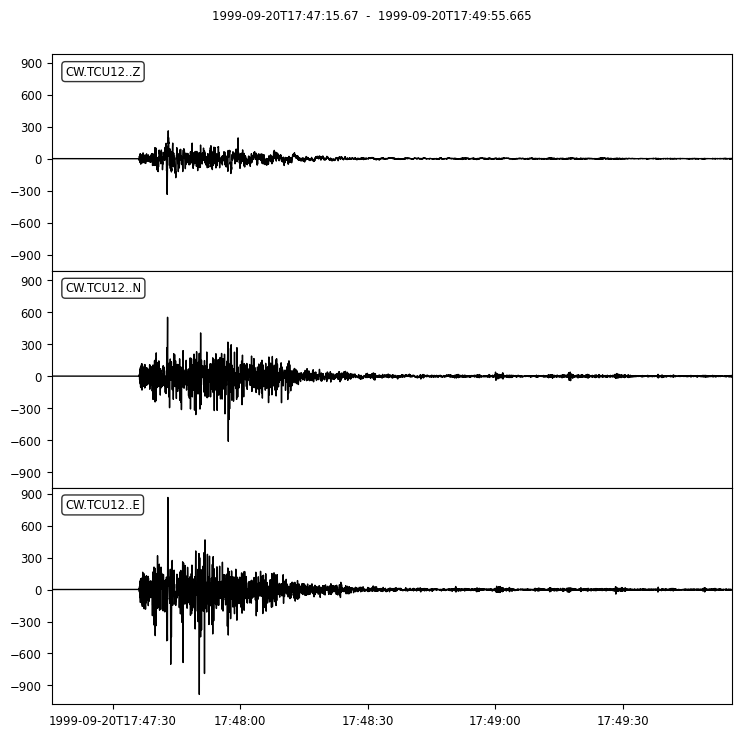

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.canvas.print_figure(bytes_io, **kw)


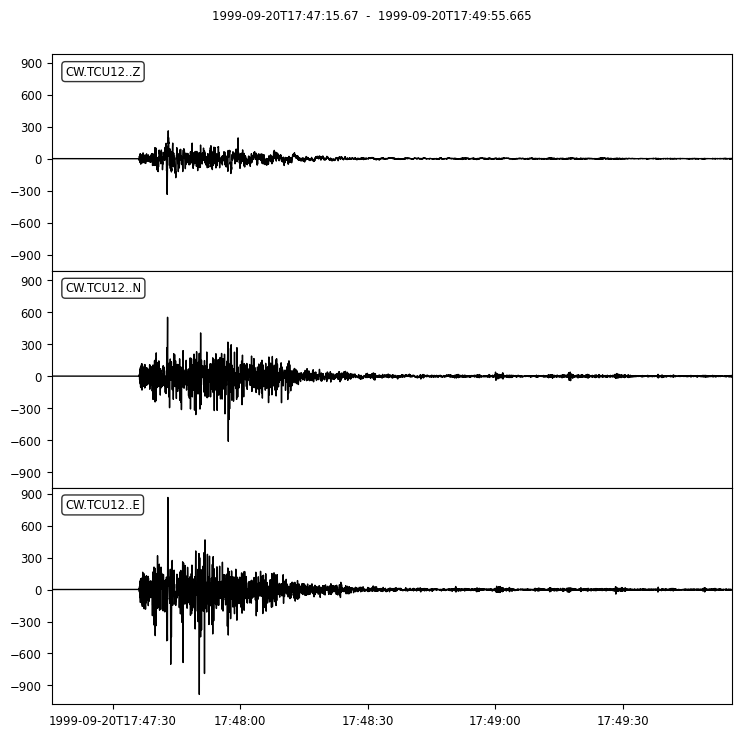

In [69]:
from obspy import read

sta = read('/content/CWB.TCU129.Z.1999-09-20T17:47:15.670000Z.mseed')
sta += read('/content/CWB.TCU129.N.1999-09-20T17:47:15.670000Z.mseed')
sta += read('/content/CWB.TCU129.E.1999-09-20T17:47:15.670000Z.mseed')

sta.plot()

### 1.5 Memotong data

Agar data yang diolah sama dengan pada referensi paper maka data akan kita potong dengan hanya mengambil 90 detik pertama:

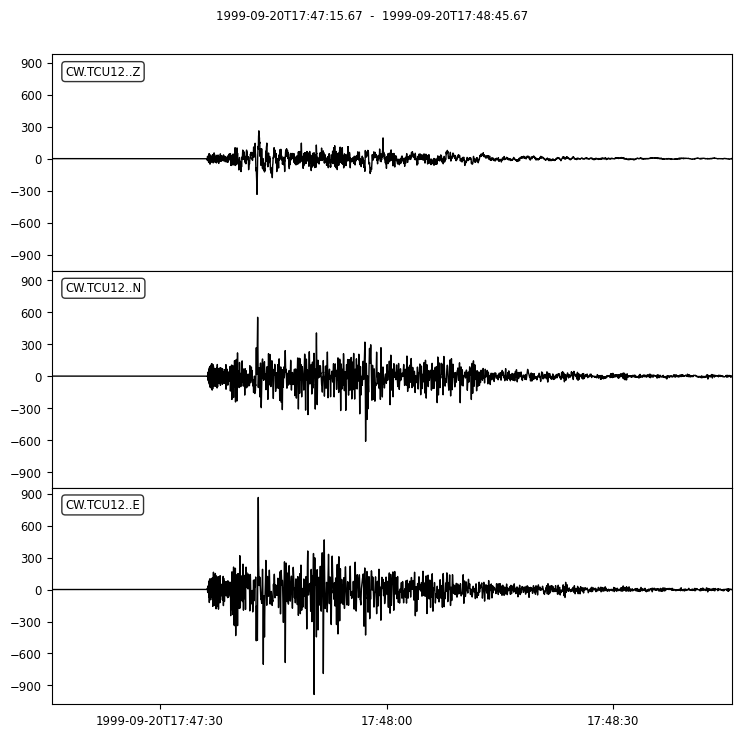

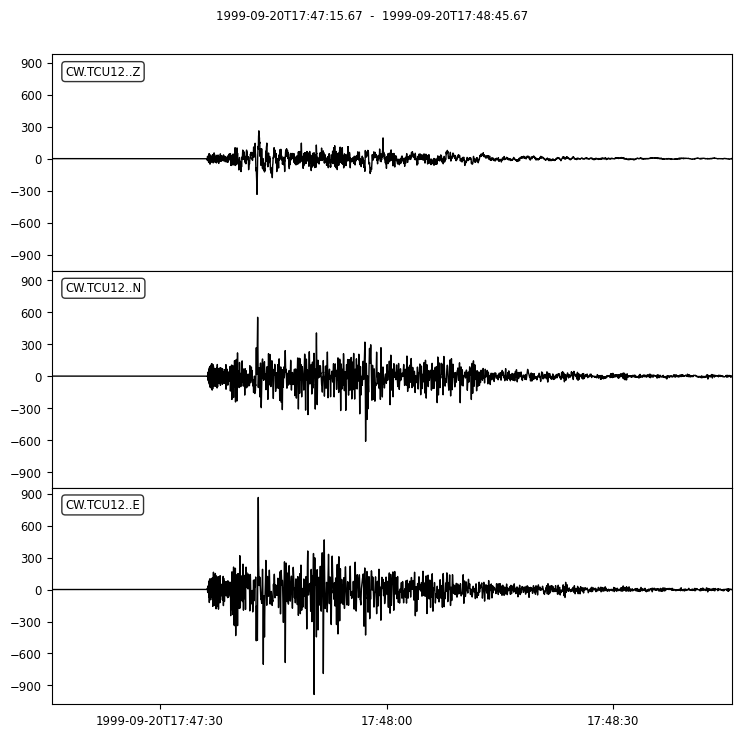

In [70]:
starttime = sta[0].stats.starttime
endtime = starttime+90

sta.trim(starttime, endtime)
sta.plot()

### 1.6 Memilih komponen E

Data yang akan diolah pada contoh ini adalah untuk komponen E dahulu, kita bisa memilih komponen dengan `Stream.select`:

1 Trace(s) in Stream:
CW.TCU12..E | 1999-09-20T17:47:15.670000Z - 1999-09-20T17:48:45.670000Z | 200.0 Hz, 18001 samples


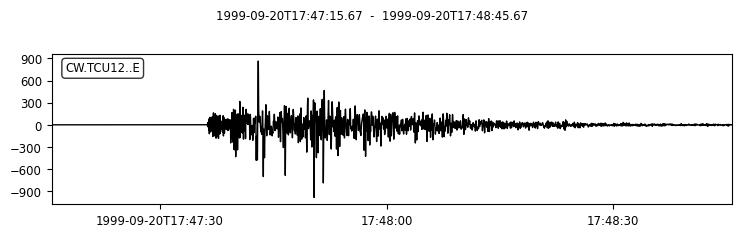

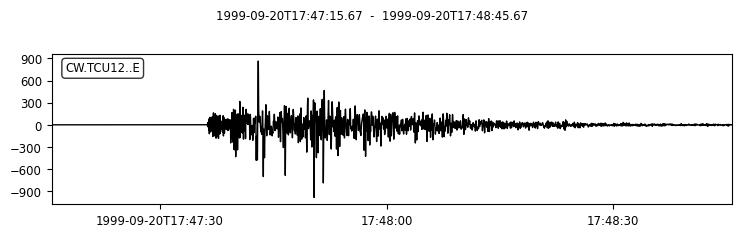

In [71]:
sta_e = sta.copy()
sta_e = sta_e.select(channel='E')
print(sta_e)

sta_e.plot()

## 2 Melakukan integrasi untuk mendapatkan kecepatan dan simpangan (*displacement*)

Sama seperti pada materi sebelumnya data akselerasi dapat kita integrasi menjadi kecepatan dan simpangan (*displacement*).

### 2.1 Integrasi untuk mendapatkan kecepatan

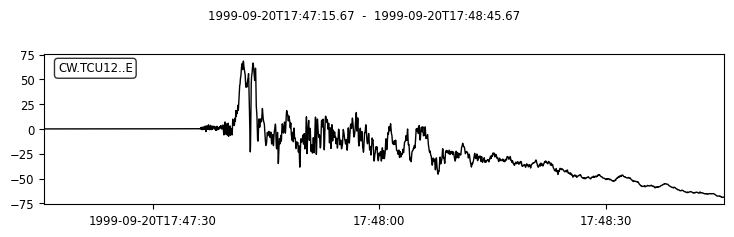

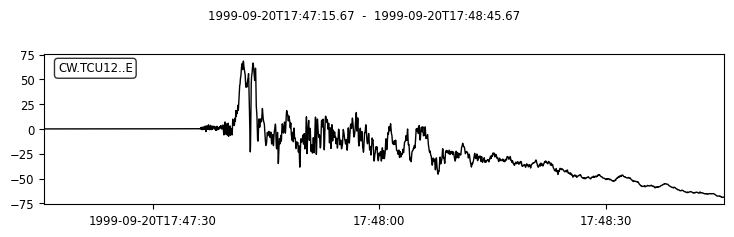

In [72]:
stv_e = sta_e.copy()
stv_e.integrate()
stv_e.plot()

Pada hasil integrasi di atas terlihat adanya bentuk gelombang yang tidak realistis karena kecepatan akhir terus bertambah dan tidak menjadi nol kembali.

### 2.2 Integrasi untuk mendapatkan simpangan (*displacement*)

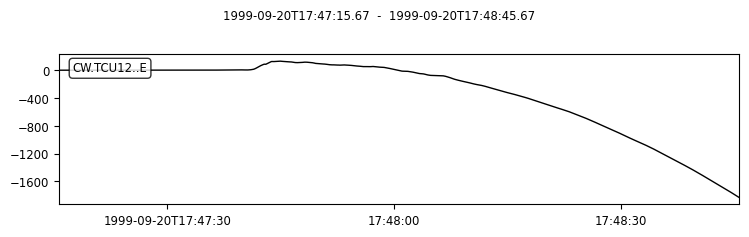

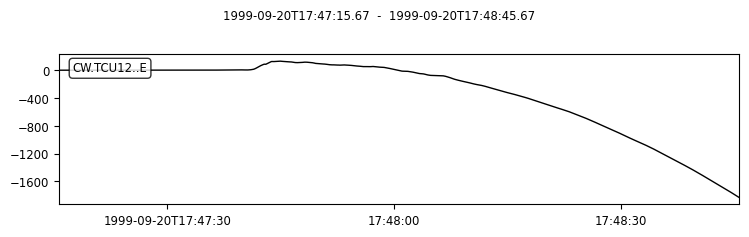

In [73]:
std_e = stv_e.copy()
std_e.integrate()
std_e.plot()

Kita juga bisa mengombinasikan 3 `Trace` menjadi 1 `Stream`:

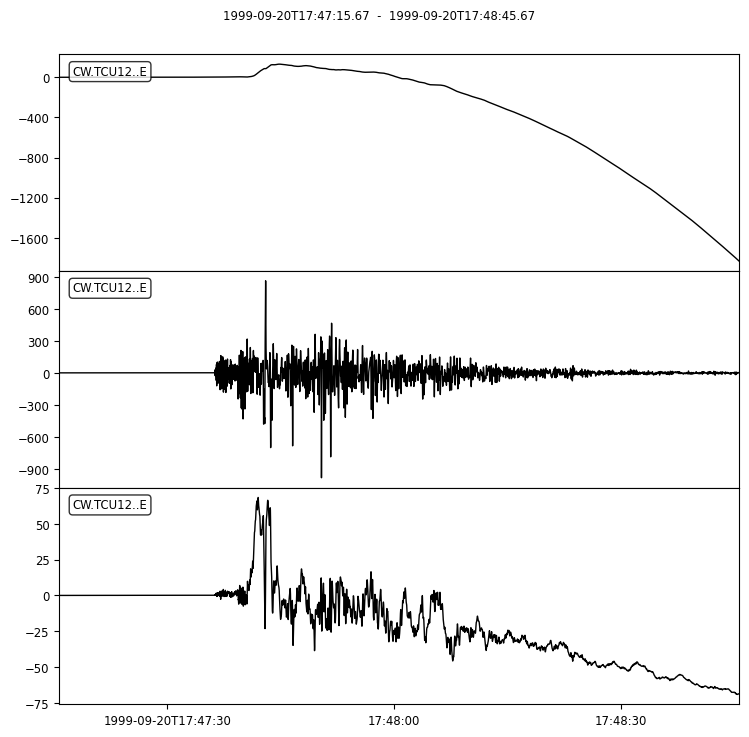

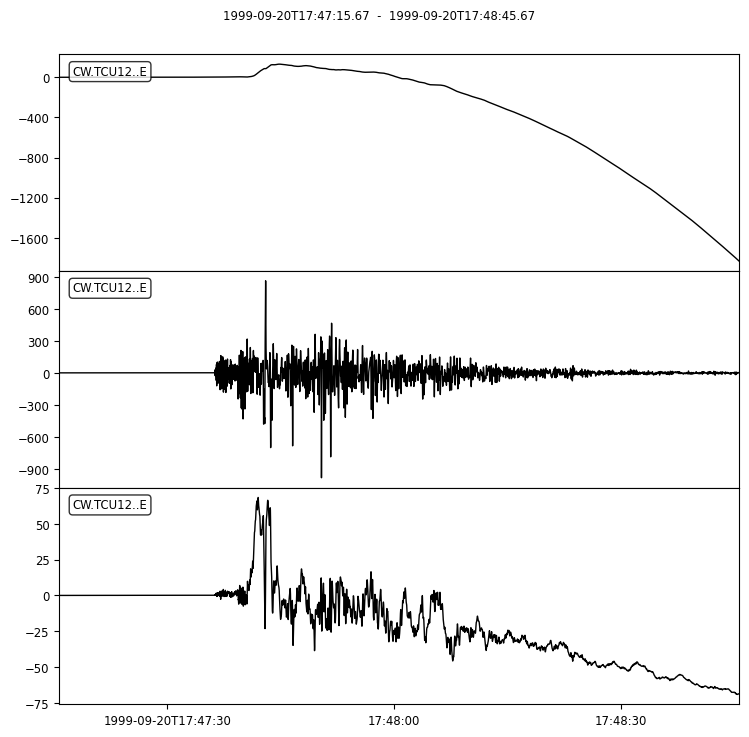

In [74]:
from obspy import Stream

stc_e = Stream(traces=[sta_e[0], stv_e[0], std_e[0]])
stc_e.plot(equal_scale=False)

## 3 Koreksi Baseline Sederhana

Kita akan melakukan koreksi baseline dengan rerata data sebelum gempa (*pre event*) pada 18 detik pertama, pemrosesan akan menggunakan `scipy`. Proses ini sama seperti pada Step 1 referensi paper. Data sebenarnya sudah dilakukan proses ini hanya kita demonstrasikan cara koreksi dengan `Python`:

### 3.1 Mengambil data dari `Stream`

Data waktu dapat diambil dari `Trace.times()` dan data rekaman diambil dari `Trace.data`. `Trace` diambil dengan menggunakan indeks `sta_e[0]`:

In [75]:
times = sta_e[0].times()
sta_e_data = sta_e[0].data
sta_e_data

array([-0.17962647,  0.        ,  0.05987549, ..., -1.73638916,
       -1.07775879, -0.95800781])

Pasangan waktu dan data rekaman dapat kita plot dengan `matplotlib`"

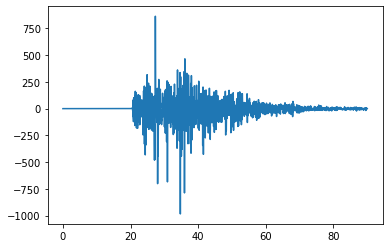

In [76]:
import matplotlib.pyplot as plt

plt.plot(times, sta_e_data)

### 3.2 Mengambil data *pre-event*

Data sebelum event akan diambil pada 0-18 sekon, untuk data dalam bentuk `numpy.array` kita dapat memanfaatkan `np.where`. Fungsi ini akan memberikan indeks dimana nilai sesuai dengan kondisi yang kita inginkan:

In [77]:
import numpy as np

pre_event_index=np.where((times>0) & (times<=18))
pre_event_index

(array([   1,    2,    3, ..., 3598, 3599, 3600]),)

selanjutnya kita dapat mengambil data yang kita inginkan (0-18 sekon):

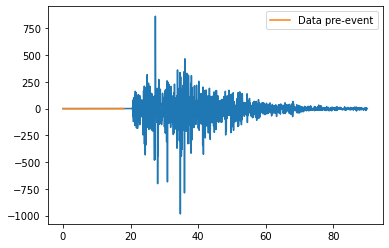

In [78]:
times_preev = times[pre_event_index]
sta_e_data_preev = sta_e_data[pre_event_index]

plt.plot(times, sta_e_data)
plt.plot(times_preev, sta_e_data_preev, label='Data pre-event')
plt.legend()

### 3.3 Menghitung koreksi *baseline* dengan *pre-event*

Rerata dari `pre-event` dapat dihitung dengan mudah menggunakan `numpy.array.mean`:

In [79]:
simple_baseline_coeff=sta_e_data.mean()
print(simple_baseline_coeff)

-0.7634964629307261


Koreksi dapat kita lakukan dengan operasi matematika sederhana:

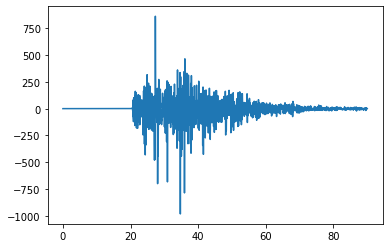

In [80]:
sta_e_data = sta_e_data-simple_baseline_coeff
plt.plot(times, sta_e_data)

### 3.4 Melakukan integrasi untuk mendapatkan kecepatan dan *displacement*

Data terlebih dahulu dikonversi ke dalam objek `Stream`:

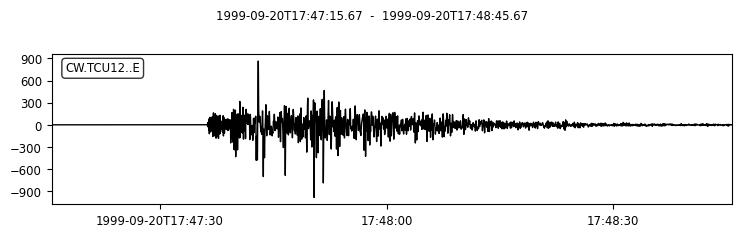

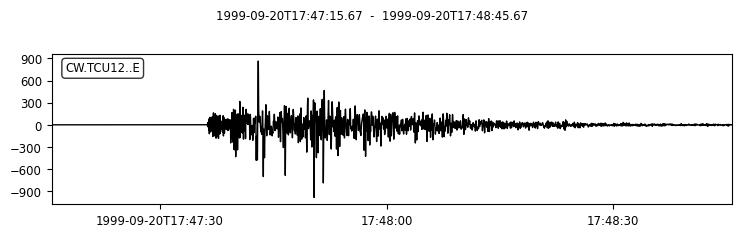

In [119]:
sta_e_cor_simple = sta_e[0].copy()
sta_e_cor_simple.data = sta_e_data
sta_e_cor_simple.plot()

kemudian mengintegrasikan ke kecepatan:

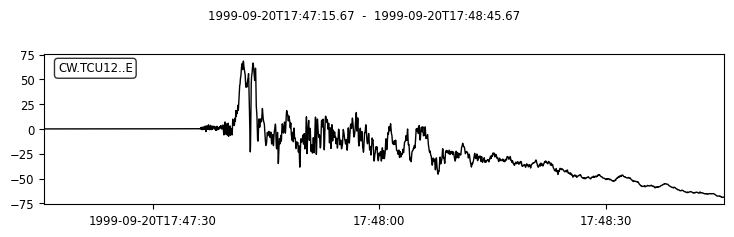

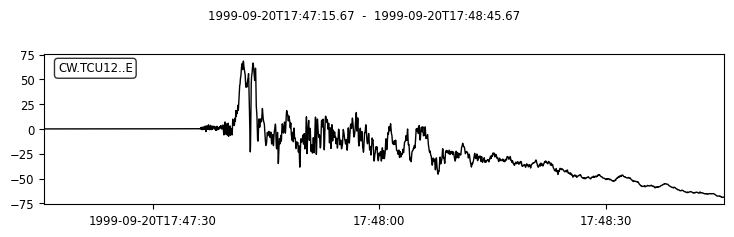

In [120]:
sta_e_cor_simple_vel = sta_e_cor_simple.copy()
sta_e_cor_simple_vel.integrate()

sta_e_cor_simple_vel.plot()

dan *displacement*:

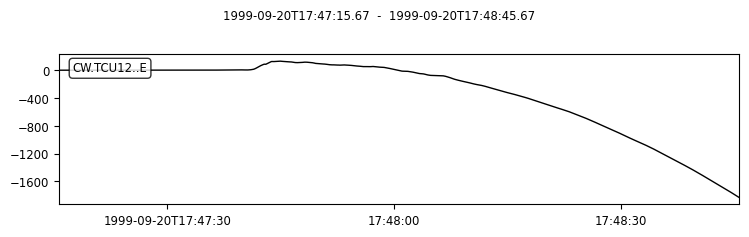

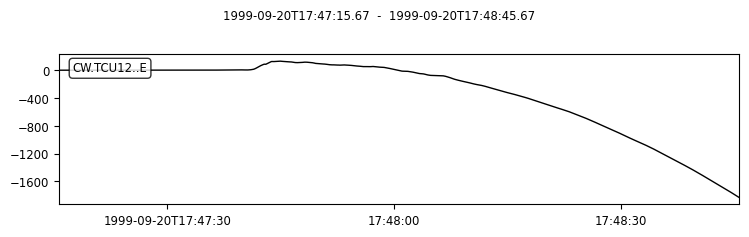

In [121]:
sta_e_cor_simple_disp = sta_e_cor_simple_vel.copy()
sta_e_cor_simple_disp.integrate()

sta_e_cor_simple_disp.plot()

## 4 Koreksi Baseline dengan *Fitting* Data *Event*

Pada koreksi ini *fitting* garis akan dilakukan pada data *event*:

### 4.1 Mengambil data

Pengambilan data sama seperti pada proses 3.1 menggunakan bantuan `numpy.where`:

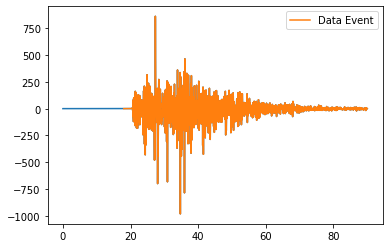

In [81]:
event_index=np.where((times>18))

sta_e_data_event = sta_e_data[event_index]
times_event = times[event_index]

plt.plot(times, sta_e_data)
plt.plot(times_event, sta_e_data_event, label='Data Event')
plt.legend()

### 4.2 Kalkulasi parameter *fitting*

Parameter *fitting* dapat dilakukan dengan regresi memanfaatkan `scipy.stats.linregress`:

In [82]:
import scipy

regression = scipy.stats.linregress(times_event, sta_e_data_event)
slope = regression[0]
intercept = regression[1]
print(slope, intercept)

-0.020495715458913096 0.914237845788737


Garis hasil regresi dapat diplot:

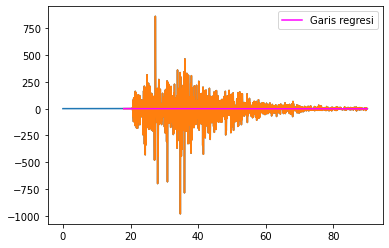

In [83]:
trend_event = times_event*slope + intercept

plt.plot(times, sta_e_data)
plt.plot(times_event, sta_e_data_event)
plt.plot(times_event, trend_event, color='magenta', label="Garis regresi")
plt.legend()

### 4.1 Melakukan koreksi

Koreksi dilakukan dengan pengurangan:

In [84]:
sta_e_data_event_cor_fit = sta_e_data_event - trend_event
sta_e_data_event_cor_fit

array([ 0.098533  ,  0.21838645,  0.15861344, ..., -0.04272111,
        0.61601174,  0.7358652 ])

Jika diplot tidak terlalu terlihat perbedaan karena memang mendekati garis lurus di 0:

(34.0, 36.0)

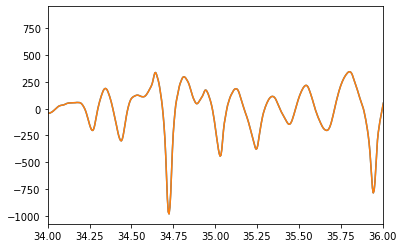

In [85]:
plt.plot(times_event, sta_e_data_event)
plt.plot(times_event, sta_e_data_event_cor_fit)

plt.xlim(34,36)

### 4.4 Mengubah data event menjadi data yang sudah terkoreksi

Karena indeks *event* sudah didapatkan maka data terkoreksi bisa dimasukkan ke data:

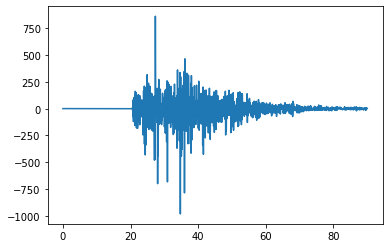

In [86]:
sta_e_data_cor_fit = sta_e_data.copy()
sta_e_data_cor_fit[event_index] = sta_e_data_event_cor_fit

plt.plot(times, sta_e_data_cor_fit)

### 4.5 Mengintegrasi untuk mendapatkan kecepatan dan simpangan

Data terlebih dahulu dikonversi ke dalam objek `Stream`:

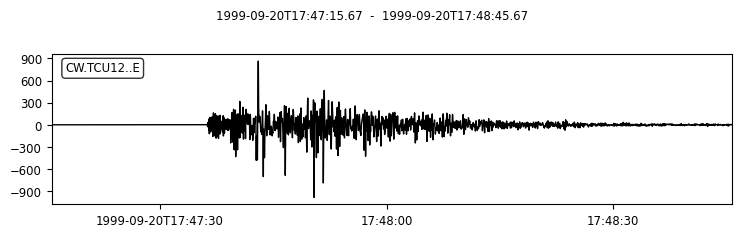

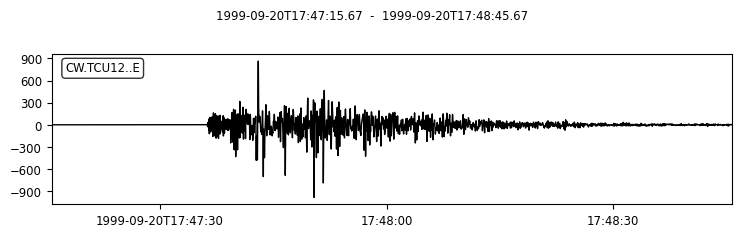

In [116]:
sta_e_cor_fit = sta_e[0].copy()
sta_e_cor_fit.data = sta_e_data_cor_fit
sta_e_cor_fit.plot()

Integrasi ke kecepatan:

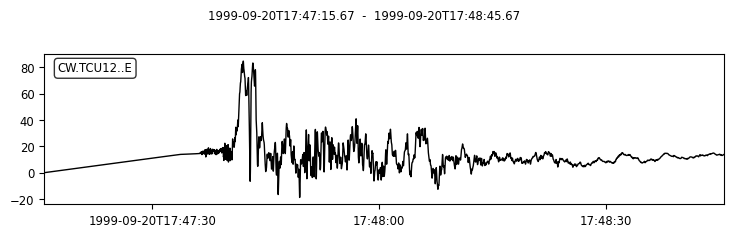

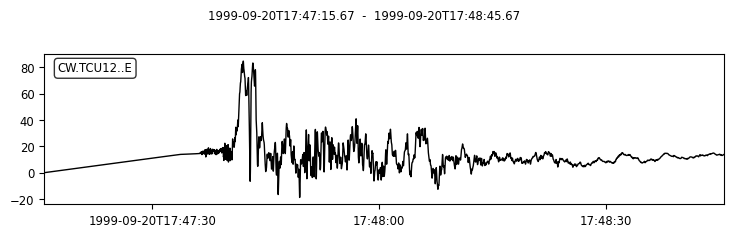

In [117]:
sta_e_cor_fit_vel = sta_e_cor_fit.copy()
sta_e_cor_fit_vel.integrate()

sta_e_cor_fit_vel.plot()

Integrasi ke simpangan:

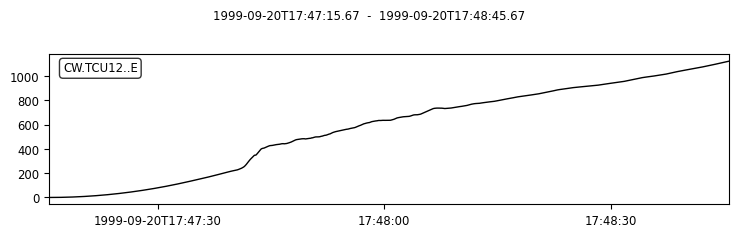

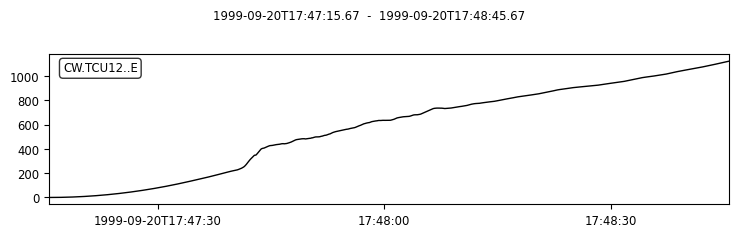

In [118]:
sta_e_cor_fit_disp = sta_e_cor_fit_vel.copy()
sta_e_cor_fit_disp.integrate()

sta_e_cor_fit_disp.plot()

## 5 Mengaplikasikan Filter Akausal

Langkah selanjutnya setelah melakukan koreksi pada langkah (4) berdasarkan referensi maka kita dapat melakukan filter *highpass* Butterworth orde 2 dengan frekuensi 0.05 akausal dengan bantuan `obspy`.


### 5.1 Konversi data `numpy.array` ke dalam objek `Stream`

Agar data dapat diolah menggunakan `obspy` maka terlebih dahulu kita buat `Trace` dengan data yang telah kita olah pada tahap sebelumnya. Proses diawali dengan menyalin(*copy*) data asli kemudian mengubah isi data menjadi data yang sudah dikoreksi:

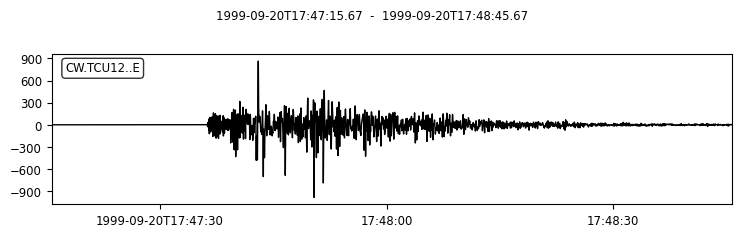

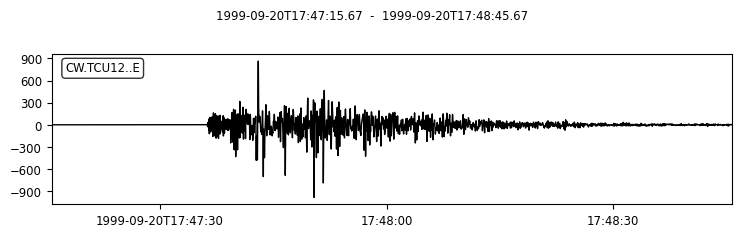

In [87]:
sta_e_cor_fit = sta_e[0].copy()
sta_e_cor_fit.data = sta_e_data_cor_fit
sta_e_cor_fit.plot()

### 5.2 Melakukan *filtering*

Selanjutnya melakukan *filtering*

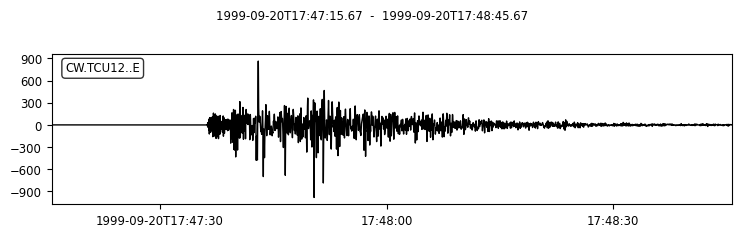

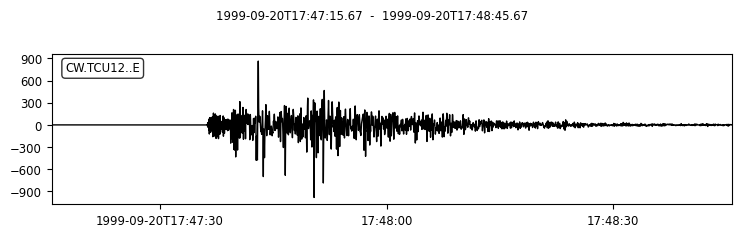

In [88]:
f=0.05
zerophase=True #akausal
corner=2
sta_e_cor_fit_filt1 = sta_e_cor_fit.copy()
sta_e_cor_fit_filt1.filter('highpass', freq=f, zerophase=zerophase, corners=corner)
sta_e_cor_fit_filt1.plot()

### 5.3 Melakukan integrasi untuk mendapatkan kecepatahan getaran tanah

Setelah *filtering* selanjutnya dilakukan integrasi untuk mendapatkan gerakan tanah dengan proses yang sama seperti sebelumnya:

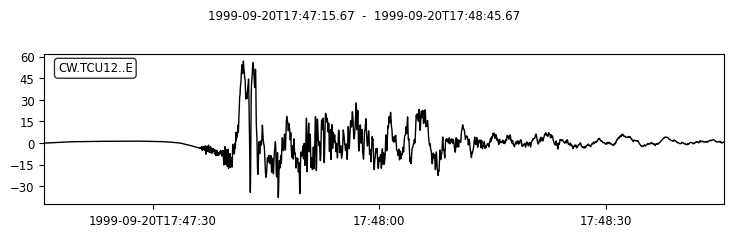

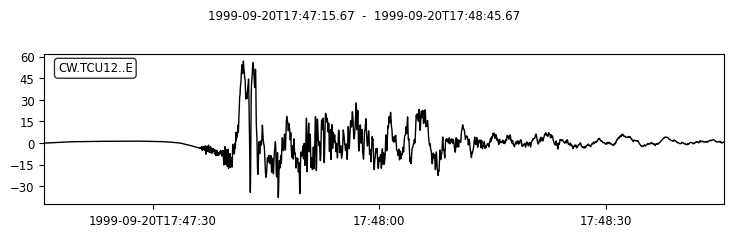

In [89]:
sta_e_cor_fit_filt1_vel = sta_e_cor_fit_filt1.copy()
sta_e_cor_fit_filt1_vel.integrate()

sta_e_cor_fit_filt1_vel.plot()

Dari hasil integrasi di atas terdapat data transien sebelum *event* yang dapat mengurangi nilai puncak

### 5.4 Melakukan integrasi untuk mendapatkan simpangan (*displacement*) tanah

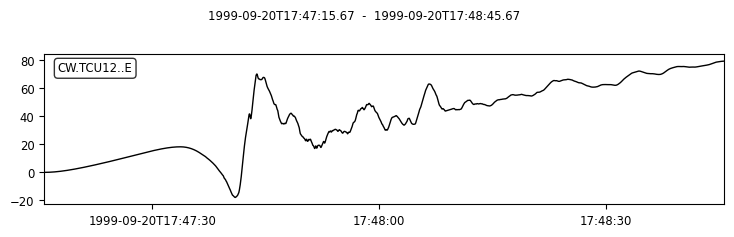

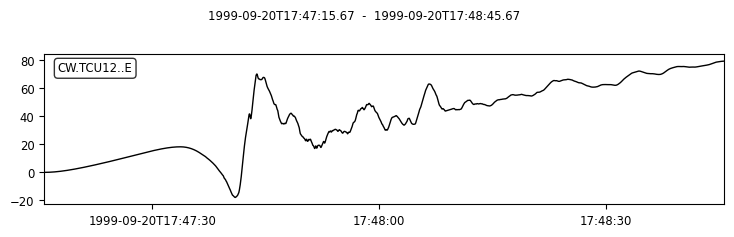

In [90]:
sta_e_cor_fit_filt1_disp = sta_e_cor_fit_filt1_vel.copy()
sta_e_cor_fit_filt1_disp.integrate()

sta_e_cor_fit_filt1_disp.plot()

Efek dari sinyal transien masih terlihat dan mempengaruhi hasil konversi.

## 6 Mengaplikasikan Filter Kausal

Penyelesaian masalah sinyal transien pada filter (5) adalah dengan menggunakan filter kausal, proses yang dilakukan adalah mirip hanya saja untuk parameter `zerophase` diganti menjadi `False`:

### 6.1 Mengaplikasikan filter kausal

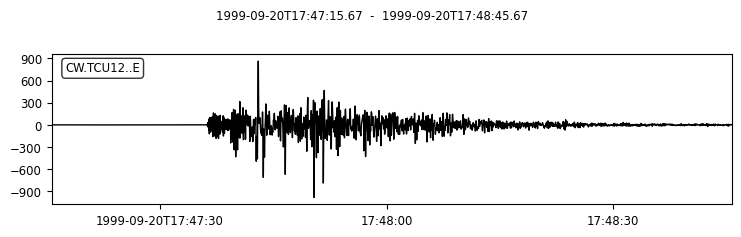

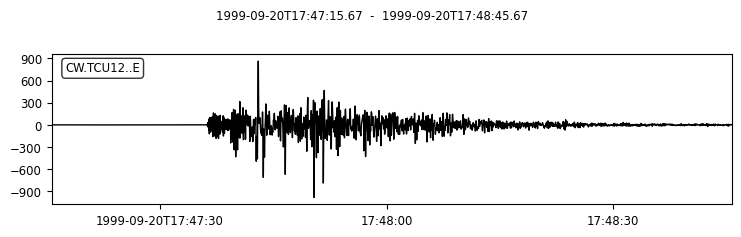

In [91]:
f=0.05
zerophase=False
corner=2
sta_e_cor_fit_filt2 = sta_e_cor_fit.copy()
sta_e_cor_fit_filt2.filter('highpass', freq=f, zerophase=zerophase, corners=corner)
sta_e_cor_fit_filt2.plot()

### 6.2 Melakukan integrasi untuk mendapatkan kecepatahan getaran tanah

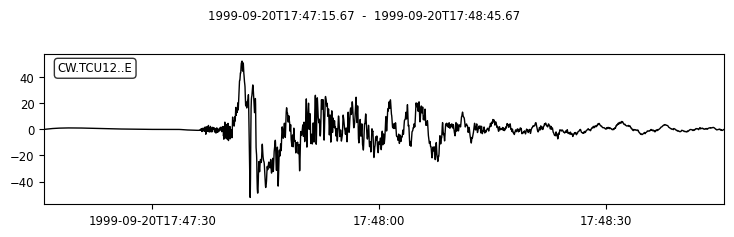

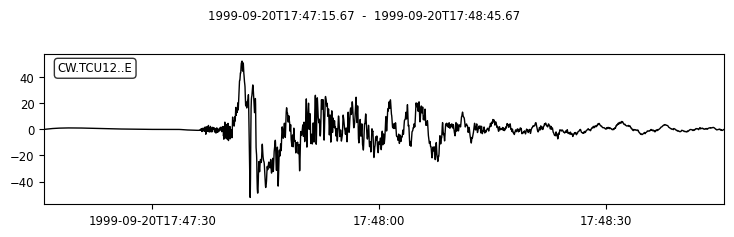

In [92]:
sta_e_cor_fit_filt2_vel = sta_e_cor_fit_filt2.copy()
sta_e_cor_fit_filt2_vel.integrate()

sta_e_cor_fit_filt2_vel.plot()

Dari hasil *filter* di atas sinyal transien tidak muncul seperti pada kasus filter akausal.

### 6.3 Melakukan integrasi untuk mendapatkan simpangan tanah

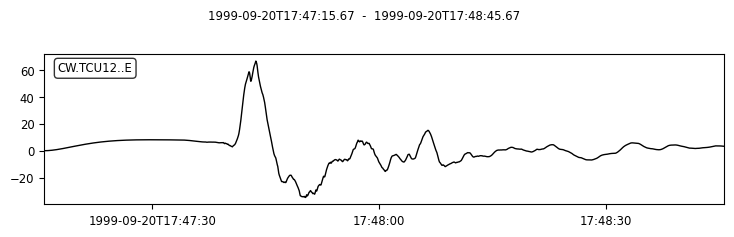

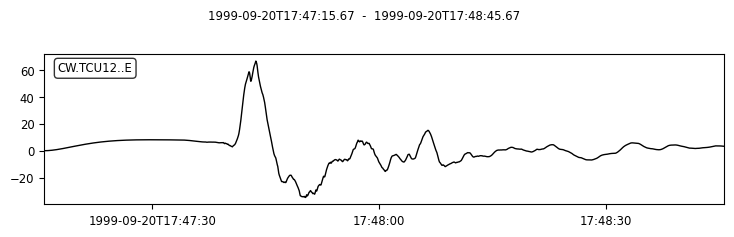

In [93]:
sta_e_cor_fit_filt2_disp = sta_e_cor_fit_filt2_vel.copy()
sta_e_cor_fit_filt2_disp.integrate()

sta_e_cor_fit_filt2_disp.plot()

## 7 Menggunakan Metode Iwan dkk (1985) Opsi 1

Koreksi `baseline` yang sedikit lebih kompleks diperkenalkan oleh Iwan dkk (1985). Metode ini didasari dari adanya efek histerisis pada transduser ketika akselerasi melebihi 50 cm/s/s. Efek ini menimbulkan pergeseran akselerasi dalam bentuk *step* yang parameternya bisa didapatkan dari melakukan *fitting* garis lurus pada kecepatan. 



### 7.1 Mendapatkan nili $t_1$ dan $t_2$ untuk analisis

Dengan metode Iwan opsi 1 analisis akan dibagi menjadi 3 bagian yang dibatasi oleh nilai $t_1$ dan nilai $t_2$. Data sebelum nilai $t_1$ merupakan data *pre-event*, diantara $t_1$ dan $t_2$ merupakan inti akselerasi tanah, dan setelah $t_1$ merupakan data setelah *event*. Nilai $t_1$ mengambil titik dimana nilai akselerasi pertama kali bernilai lebih dari 50 cm/s/s dan nilai $t_2$ adalah titik dimana data sudah mulai bernilai kurang dari 50 cm/s/s, berkaitan dengan fenomena histerisis tadi. Nilai $t_1$ dan $t_2$ dapat juga dikaitakan dengan periode guncangan yang tertinggi. Proses pengambilan nilai memanfaatkan `numpy.where` seperti proses sebelumnya:

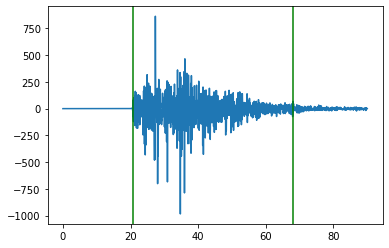

In [94]:
import numpy as np
import matplotlib.pyplot as plt

sta_e_data = sta_e[0].data

sta_data_higher50_index = np.where((sta_e_data>50))

t1_index = sta_data_higher50_index[0][0]
t2_index = sta_data_higher50_index[0][-1] + 1

t1 = times[t1_index]
t2 = times[t2_index]

plt.plot(times, sta_e_data)
plt.axvline(x=t1, color="green")
plt.axvline(x=t2, color="green")

Dalam kecepatan:

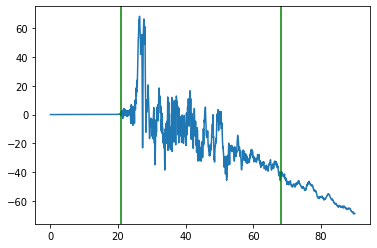

In [95]:
stv_e_data = stv_e[0].data

plt.plot(times, stv_e_data)
plt.axvline(x=t1, color="green")
plt.axvline(x=t2, color="green")

### 7.2 Menghitung nilai $a_f$

NIlai $a_f$ merupakan nilai yang didapatkan dengan menghitung gradien dari $t_1$ sampai akhir rekaman dengan persamaan:

$$
v_f(t) = v_0 + a_f t
$$


Dalam penerapannya proses ini memanfaatkan *slicing* indeks dan perhitungan regresi menggunakan `scipy.stats.linregress`:

slope:  -1.156331846971815


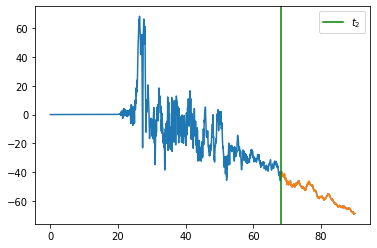

In [96]:
import scipy

times_after_50 = times[t2_index:]
stv_e_data_after_50 = stv_e_data[t2_index:]

plt.plot(times, stv_e_data)
plt.plot(times_after_50, stv_e_data_after_50)

plt.axvline(x=t2, color="green", label="$t_2$")
regression_iwan1_after_50 = scipy.stats.linregress(times_after_50, stv_e_data_after_50)
print("slope: ",regression_iwan1_after_50[0])
plt.legend()

-1.156331846971815 36.24933248149239


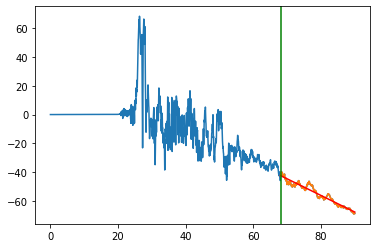

In [97]:
regression_iwan1_after_50 = scipy.stats.linregress(times_after_50, stv_e_data_after_50)
slope_iwan1_after_50 = regression_iwan1_after_50[0]
intercept_iwan1_after_50 = regression_iwan1_after_50[1]

print(slope_iwan1_after_50, intercept_iwan1_after_50)
line_fit_iwan1_after_50 = times_after_50*slope_iwan1_after_50 + intercept_iwan1_after_50

plt.plot(times, stv_e_data)
plt.plot(times_after_50, stv_e_data_after_50)
plt.plot(times_after_50, line_fit_iwan1_after_50, color="red")
plt.axvline(x=t2, color="green")

Dari kode di atas didapatkan nilai $a_f=-1.156$

### 7.2 Menghitung nilai $a_m$

Nilai $a_m$ digunakan untuk koreksi data akselerasi di zona guncangan tinggi yaitu diantara $t_1$ dan $t_2$, nilai ini didapatkan dari melakukan regresi atau perhitungan gradien sederhana dari data antara $t_1$ dan $t_2$ dengan $v_f(t_1)=0$:
$$
a_m = \frac{v_f(t_2)}{t_2-t_1}
$$

Kita terlebih dahulu mengambil data antara $t_1$ dan $t_2$:


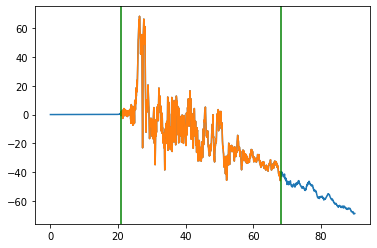

In [98]:
times_between_50 = times[t1_index:t2_index]
stv_e_data_between_50 = stv_e_data[t1_index:t2_index]

plt.plot(times, stv_e_data)
plt.plot(times_between_50, stv_e_data_between_50)

plt.axvline(x=t1, color="green")
plt.axvline(x=t2, color="green")

kemudian melakukan regresi seperti pada proses sebelumnya:

-0.9154329987712069 19.646331011115382
slope:  -0.9154329987712069


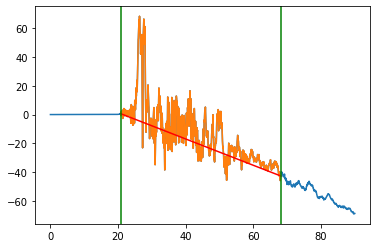

In [99]:
import scipy

times_between_50_bound = [times_between_50[0],times_between_50[-1]]
stv_e_data_between_50_bound = [stv_e_data_between_50[0],stv_e_data_between_50[-1]]

regression_iwan1_between_50 = scipy.stats.linregress(times_between_50_bound, stv_e_data_between_50_bound)
slope_iwan1_between_50 = regression_iwan1_between_50[0]
intercept_iwan1_between_50 = regression_iwan1_between_50[1]

print(slope_iwan1_between_50, intercept_iwan1_between_50)
line_fit_iwan1_between_50 = times_between_50*slope_iwan1_between_50 + intercept_iwan1_between_50

plt.plot(times, stv_e_data)
plt.plot(times_between_50, stv_e_data_between_50)
plt.plot(times_between_50, line_fit_iwan1_between_50, color="red")
plt.axvline(x=t1, color="green")
plt.axvline(x=t2, color="green")
print("slope: ",slope_iwan1_between_50)

### 7.4 Membuat data koreksi dalam akselerasi

Dengan nilai $a_f$ dan $a_m$ maka kedua nilai tersebut dapat digunakan untuk mengoreksi data dalam akselerasi. Pertama kita harus membuat *placeholder* untuk meletakkan data koreksi, dibuat menggunakan vektor berisi 1 dengan panjang sesuai panjang data:

In [100]:
sta_e_iwan1_cor_coeff = np.ones(len(sta_e_data))
sta_e_iwan1_cor_coeff

array([1., 1., 1., ..., 1., 1., 1.])

Selanjutnya masing-masing bagian diisi sesuai dengan nilainya:

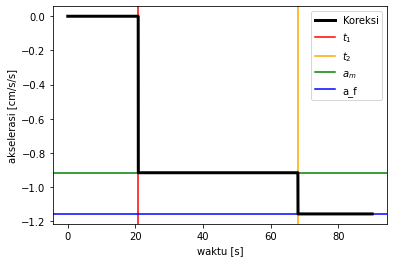

In [101]:
sta_e_iwan1_cor_coeff[:t1_index] = 0
sta_e_iwan1_cor_coeff[t1_index:t2_index] = slope_iwan1_between_50
sta_e_iwan1_cor_coeff[t2_index:] = slope_iwan1_after_50

plt.plot(times, sta_e_iwan1_cor_coeff, zorder=110, linewidth=3, color="k", label="Koreksi")
plt.axvline(x=t1, label="$t_1$", color="red")
plt.axvline(x=t2, label="$t_2$", color="orange")
plt.axhline(y=slope_iwan1_between_50, color="green", label="$a_m$")
plt.axhline(y=slope_iwan1_after_50, color="blue", label="a_f")
plt.xlabel("waktu [s]")
plt.ylabel("akselerasi [cm/s/s]")
plt.legend()

### 7.5 Melakukan koreksi

Koreksi dilakukan dengan operasi matematika sederhana:

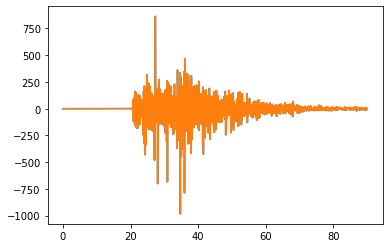

In [102]:
sta_e_iwan1_corrected = sta_e_data - sta_e_iwan1_cor_coeff

plt.plot(times, sta_e_data)
plt.plot(times, sta_e_iwan1_corrected)

### 7.6 Mengintegrasikan untuk mendapatkan kecepatan

Data terkoreksi bisa dikonversi ke objek `Stream` untuk selanjutnya nanti dikonversi ke kecepatan:

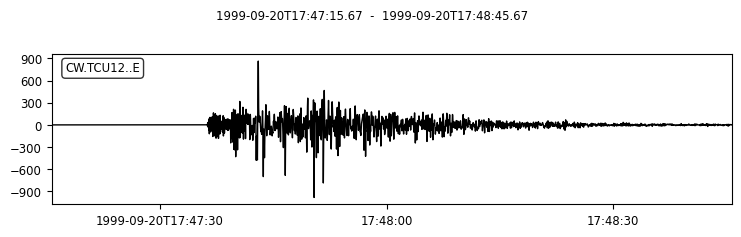

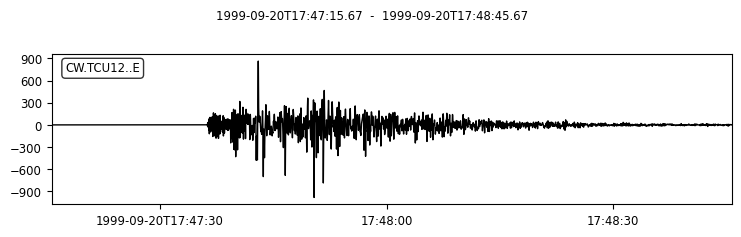

In [103]:
sta_e_cor_iwan1 = sta_e[0].copy()
sta_e_cor_iwan1.data = sta_e_iwan1_corrected
sta_e_cor_iwan1.plot()

konversi ke kecepatan dengan integrasi:

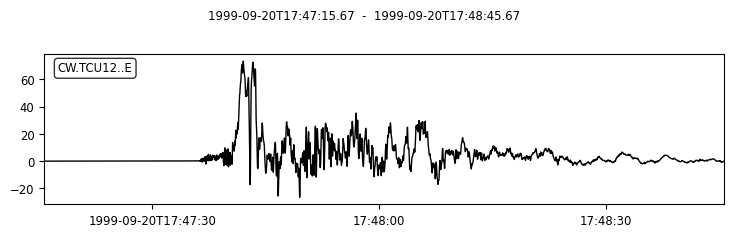

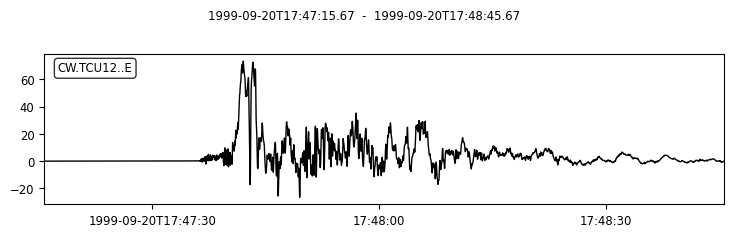

In [104]:
stv_e_cor_iwan1 = sta_e_cor_iwan1.copy()
stv_e_cor_iwan1.integrate()
stv_e_cor_iwan1.plot()

### 7.7 Mengintegrasikan untuk mendapatkan simpangan tanah

Begitu pula untuk *displacement*

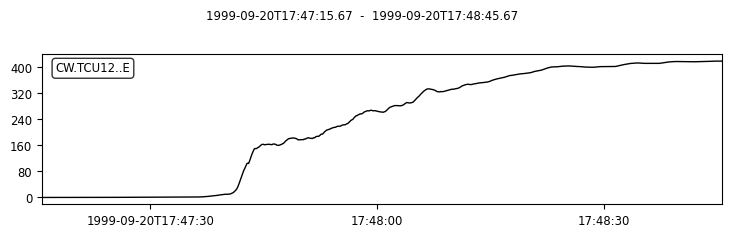

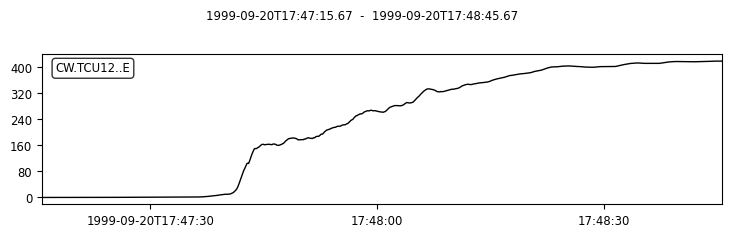

In [105]:
std_e_cor_iwan1 = stv_e_cor_iwan1.copy()
std_e_cor_iwan1.integrate()
std_e_cor_iwan1.plot()

## 8 Membandingkan hasil koreksi

### 8.1 Perbandingan akselerasi

Text(0.5, 1.0, 'Akselerasi')

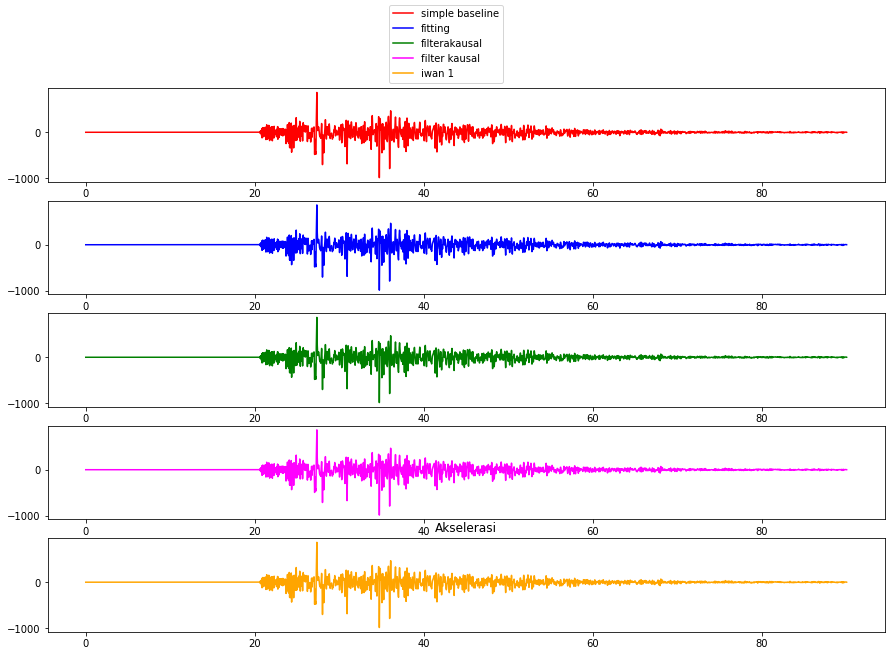

In [133]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(15,10))

# koreksi simple baseline
ax=fig.add_subplot(5,1,1)
ax.plot(times, sta_e_cor_simple.data, label='simple baseline', color="red")

# koreksi fitting
ax=fig.add_subplot(5,1,2)
ax.plot(times, sta_e_cor_fit.data, label='fitting', color="blue")

# filter akausal
ax=fig.add_subplot(5,1,3)
ax.plot(times, sta_e_cor_fit_filt1.data, label='filterakausal', color="green")

# filter kausal
ax=fig.add_subplot(5,1,4)
ax.plot(times, sta_e_cor_fit_filt2.data,label='filter kausal', color="magenta")

# metode iwan1
ax=fig.add_subplot(5,1,5)
ax.plot(times, sta_e_cor_iwan1.data, label='iwan 1', color="orange")

fig.legend(loc='upper center')
ax.set_title("Akselerasi")

### 8.2 Perbandingan kecepatan

Text(0.5, 1.0, 'Kecepatan')

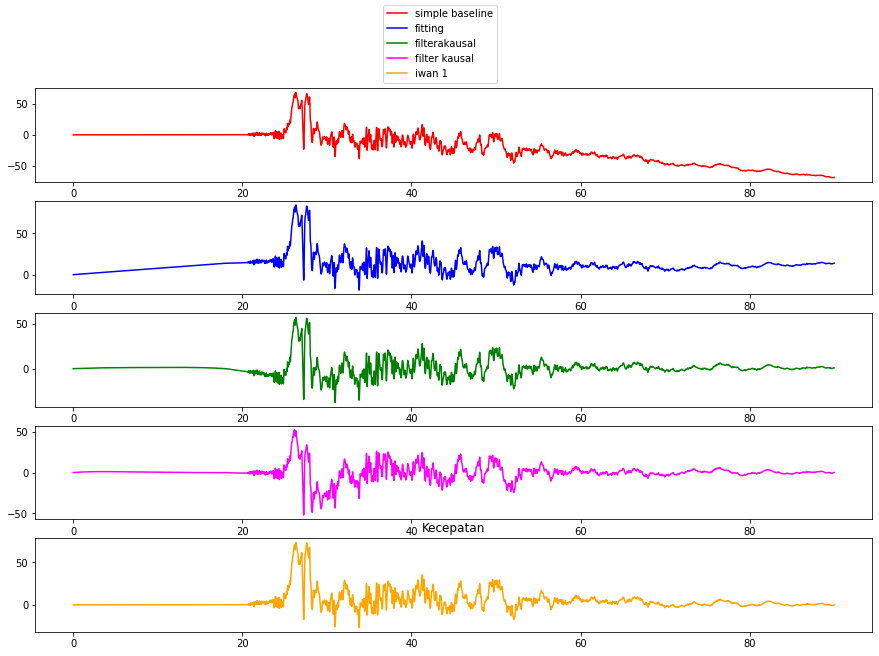

In [138]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(15,10))

# koreksi simple baseline
ax=fig.add_subplot(5,1,1)
ax.plot(times, sta_e_cor_simple_vel.data, label='simple baseline', color="red")

# koreksi fitting
ax=fig.add_subplot(5,1,2)
ax.plot(times, sta_e_cor_fit_vel.data, label='fitting', color="blue")

# filter akausal
ax=fig.add_subplot(5,1,3)
ax.plot(times, sta_e_cor_fit_filt1_vel.data, label='filterakausal', color="green")

# filter kausal
ax=fig.add_subplot(5,1,4)
ax.plot(times, sta_e_cor_fit_filt2_vel.data,label='filter kausal', color="magenta")

# metode iwan1
ax=fig.add_subplot(5,1,5)
ax.plot(times, stv_e_cor_iwan1.data, label='iwan 1', color="orange")

fig.legend(loc='upper center')
ax.set_title("Kecepatan")

### 8.3 Perbandingan *displacement*

Text(0.5, 1.0, 'Displacement')

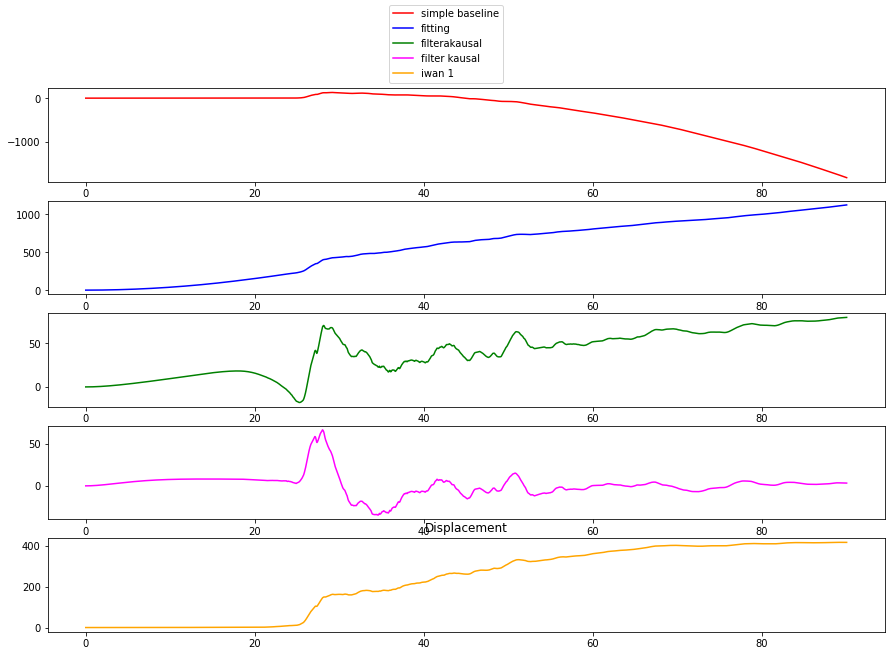

In [139]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(15,10))

# koreksi simple baseline
ax=fig.add_subplot(5,1,1)
ax.plot(times, sta_e_cor_simple_disp.data, label='simple baseline', color="red")

# koreksi fitting
ax=fig.add_subplot(5,1,2)
ax.plot(times, sta_e_cor_fit_disp.data, label='fitting', color="blue")

# filter akausal
ax=fig.add_subplot(5,1,3)
ax.plot(times, sta_e_cor_fit_filt1_disp.data, label='filterakausal', color="green")

# filter kausal
ax=fig.add_subplot(5,1,4)
ax.plot(times, sta_e_cor_fit_filt2_disp.data,label='filter kausal', color="magenta")

# metode iwan1
ax=fig.add_subplot(5,1,5)
ax.plot(times, std_e_cor_iwan1.data, label='iwan 1', color="orange")

fig.legend(loc='upper center')
ax.set_title("Displacement")

## 9 Latihan

### 9.1 Mendapatkan nilai $t_1$ dan $t_2$

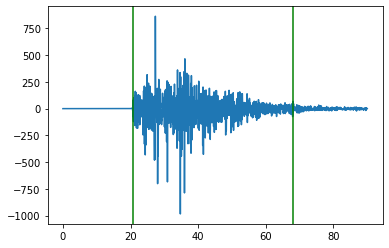

In [106]:
import numpy as np
import matplotlib.pyplot as plt

sta_e_data = sta_e[0].data

sta_data_higher50_index = np.where(#isikan disini) <------------------------ 

t1_index = sta_data_higher50_index[0][0]
t2_index = sta_data_higher50_index[0][-1] + 1

t1 = times[t1_index]
t2 = times[t2_index]

plt.plot(times, sta_e_data)
plt.axvline(x=t1, color="green")
plt.axvline(x=t2, color="green")

### 9.2 Menghitung nilai $a_f$

slope:  -1.156331846971815


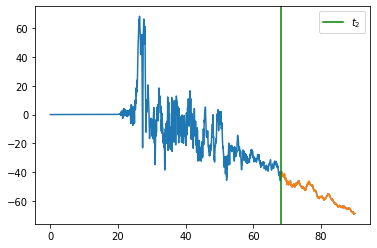

In [107]:
import scipy

times_after_50 = times[#isi disini]
stv_e_data_after_50 = stv_e_data[#isi disini]

plt.plot(times, stv_e_data)
plt.plot(times_after_50, stv_e_data_after_50)

plt.axvline(x=t2, color="green", label="$t_2$")
regression_iwan1_after_50 = scipy.stats.linregress(#isi disini)
print("slope: ",regression_iwan1_after_50[0])
plt.legend()

### 9.3 Menghitung nilai $a_m$

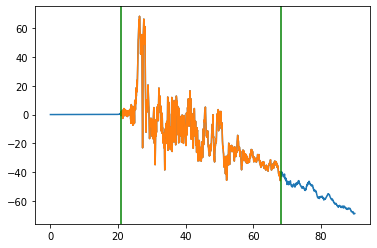

In [108]:
times_between_50 = times[#isi disini]
stv_e_data_between_50 = stv_e_data[#isi disini]

plt.plot(times, stv_e_data)
plt.plot(times_between_50, stv_e_data_between_50)

plt.axvline(x=t1, color="green")
plt.axvline(x=t2, color="green")

### 9.4 Membuat data koreksi dalam akselerasi

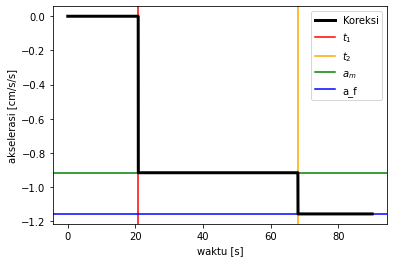

In [109]:
sta_e_iwan1_cor_coeff = np.ones(#isi disini)

sta_e_iwan1_cor_coeff[#isi disini] = #isi disini
sta_e_iwan1_cor_coeff[#isi disini] = #isi disini
sta_e_iwan1_cor_coeff[#isi disini] = #isi disini

plt.plot(times, sta_e_iwan1_cor_coeff, zorder=110, linewidth=3, color="k", label="Koreksi")
plt.axvline(x=t1, label="$t_1$", color="red")
plt.axvline(x=t2, label="$t_2$", color="orange")
plt.axhline(y=slope_iwan1_between_50, color="green", label="$a_m$")
plt.axhline(y=slope_iwan1_after_50, color="blue", label="a_f")
plt.xlabel("waktu [s]")
plt.ylabel("akselerasi [cm/s/s]")
plt.legend()


### 9.5 Melakukan koreksi

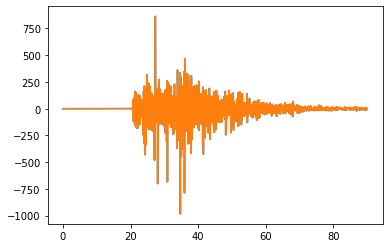

In [110]:
sta_e_iwan1_corrected = #isi disini

plt.plot(times, sta_e_data)
plt.plot(times, sta_e_iwan1_corrected)

### 9.6 Mengintegrasikan untuk mendapatkan kecepatan

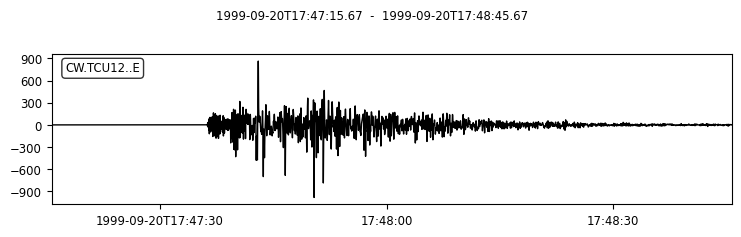

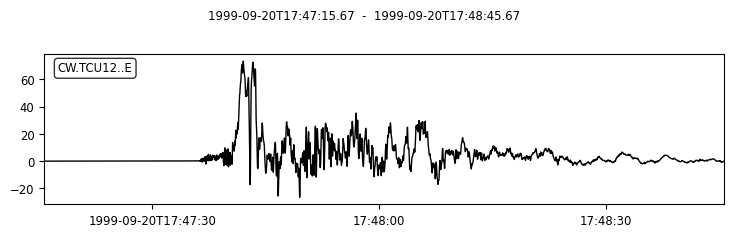

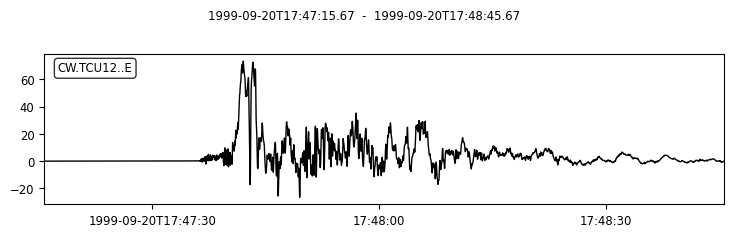

In [111]:
sta_e_cor_iwan1 = sta_e[0].copy()
sta_e_cor_iwan1.data = #isi disini
sta_e_cor_iwan1.plot()

stv_e_cor_iwan1 = sta_e_cor_iwan1.copy()
#isi disini
stv_e_cor_iwan1.plot()
